In [1]:
import pandas as pd
import sys
import numpy as np
from cameras.cameras import Amount, Camera, mean_squash_camera, wiggle_camera
from evolution.base import BaseGeometry, DenseGeometry, PlaneGeometry
from evolution.camera.camera_rendering import project_points, render_geometry_with_camera
from evolution.camera import CameraTranslator, ObjGeometry

import matplotlib.pyplot as plt
print(sys.executable)

/home/chris/Development/virtualenvironments/evolution-evaluation/bin/python


Development of a function for loading results

In [14]:
results_df = pd.read_csv("data/squash_full_data.csv")
results_df[["t_fu", "t_fv", "t_tx", "t_rz", "t_d3", "t_d2"]].describe()

,t_fu,t_fv,t_tx,t_rz,t_d3,t_d2
count,55296.0,55296.0,55296.0,55296.0,55296.0,55296.0
mean,700.0,700.0,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0
min,700.0,700.0,0.0,0.0,0.0,0.0
25%,700.0,700.0,0.0,0.0,0.0,0.0
50%,700.0,700.0,0.0,0.0,0.0,0.0
75%,700.0,700.0,0.0,0.0,0.0,0.0
max,700.0,700.0,0.0,0.0,0.0,0.0


In [26]:
configurations_df = results_df[["fitness_fn", "distance_type", "noise_type", "noise_value"]].drop_duplicates()
configurations_df

,fitness_fn,distance_type,noise_type,noise_value
0,DistanceMapWithPunishment,Near,no_noise,0.00
32,DistanceMapWithPunishment,Near,salt,0.01
64,DistanceMapWithPunishment,Near,hlines,128.00
96,DistanceMapWithPunishment,Near,vlines,128.00
128,DistanceMapWithPunishment,Near,straight_grid,128.00
160,DistanceMapWithPunishment,Near,angled_grid,128.00
4608,DistanceMap,Near,no_noise,0.00
4640,DistanceMap,Near,salt,0.01
4672,DistanceMap,Near,hlines,128.00
4704,DistanceMap,Near,vlines,128.00


In [4]:
for configuration in configurations_df:
    print(configuration)

fitness_fn
distance_type
noise_type
noise_value


In [5]:
mean_squash_camera((800, 600)).dna

array([7.00e+02, 7.00e+02, 3.00e+02, 4.00e+02, 0.00e+00, 2.35e+00,
       8.40e+00, 2.90e-01, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
       0.00e+00, 0.00e+00, 0.00e+00])

In [5]:
def translate_dna(camera_dna: np.array):
    x = camera_dna
    camera_matrix = np.array([[x[0], 0, x[2]], [0, x[1], x[3]], [0, 0, 1]], dtype=np.float32)

    t_vec = x[4:7].astype(np.float32)
    r_vec = x[7:10].astype(np.float32)
    d_vec = x[10:].astype(np.float32)

    return camera_matrix, t_vec, r_vec, d_vec

def reprojection_error(camera_a: Camera, camera_b: Camera, geometry: BaseGeometry) -> float:
    cma, ta, ra, da = translate_dna(camera_a.dna)
    cmb, tb, rb, db = translate_dna(camera_b.dna)
    projected_points_a = project_points(geometry.world_points, cma, ta, ra, da)
    projected_points_b = project_points(geometry.world_points, cmb, tb, rb, db)
    projected_points_a = projected_points_a.reshape((-1,2))
    projected_points_b = projected_points_b.reshape((-1,2))
    errors = projected_points_b - projected_points_a
    return errors


In [9]:
geometry_file = "data/squash/geometries/squash_court.obj"
image_shape = (600, 800)
geometry = ObjGeometry(geometry_file)
geometry_dense = DenseGeometry(geometry, 16)
geometry_y0 = PlaneGeometry(geometry, 0, 16)

cam_a = mean_squash_camera(image_shape)
cam_b = wiggle_camera(cam_a, Amount.near(), [i for i in range(15)], 7)


In [13]:
reprojection_error(cam_a, cam_b, geometry_dense)

array([[5.0267707 , 5.68471204],
       [5.54206126, 5.51776804],
       [5.64911636, 5.22727481],
       ...,
       [7.12311695, 4.26967253],
       [6.83082086, 3.97453907],
       [6.5634953 , 3.70247389]])

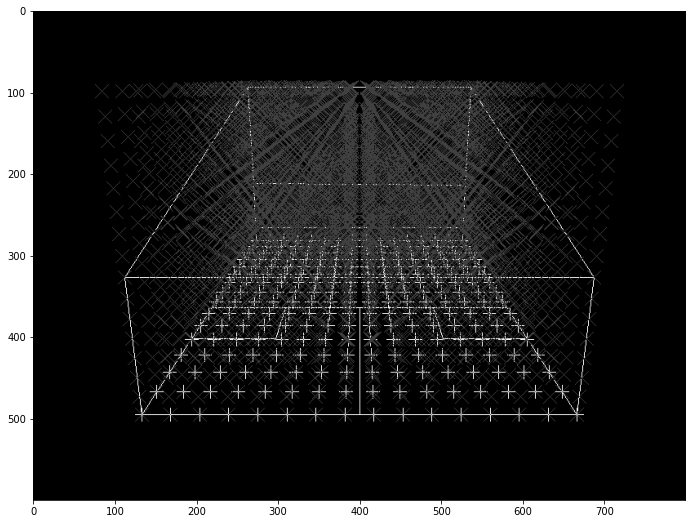

In [31]:
test_image = np.zeros(image_shape, dtype=np.uint8)
cma, ta, ra, da = translate_dna(cam_a.dna)
cmb, tb, rb, db = translate_dna(cam_b.dna)

render_geometry_with_camera(test_image, geometry, cma, ta, ra, da, (255,), 1)
render_geometry_with_camera(test_image, geometry_y0, cma, ta, ra, da, (255), 2, True)
render_geometry_with_camera(test_image, geometry_dense, cma, ta, ra, da, (64), 1, True)

fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot()
ax.imshow(test_image,cmap="gray")

In [6]:
errors = np.array([[-5.13359926, -1.00286623],
 [ 3.90467068,  0.17045128],
 [ 2.49603298,  1.24115201],
 [-3.15903772, -0.47393416],
 [-4.35515419, -0.65016197],
 [-1.67511372, -0.21691813],
 [-1.6319287 , -0.10469017],
 [-3.995781  , -0.5593235 ],
 [ 2.29013444,  0.64383736],
 [ 3.5814802 ,  1.07137424],
 [ 3.31666919,  1.2486702 ],
 [ 2.02222241,  0.79929648],
 [ 0.93745444, -0.4128502 ],
 [ 0.37337842,  0.34817974],
 [-2.84210926, -2.81428821],
 [ 4.0406909 ,  0.51757779],
 [ 3.44067235,  1.24932344],
 [-1.38665265, -1.69710027],
 [-3.0063671 , -0.64745206],
 [ 2.58314506,  1.17000407],
 [-2.50907942, -1.12098788],
 [ 2.85299371,  1.03637041]])

In [1]:


print(distances)
print()
print(errors.shape)
print(distances.shape)


NameError: name 'distances' is not defined

In [1]:
checkpoints = []

for i in range(5):
    checkpoint_x, checkpoint_y = i, i**2
    checkpoints.append([checkpoint_x, checkpoint_y])

print("   checkpoints: ", checkpoints)
print("checkpoints[3]: ", checkpoints[3])

#   checkpoints:  [[0, 0], [1, 1], [2, 4], [3, 9], [4, 16]]
#checkpoints[3]:  [3, 9]

   checkpoints:  [[0, 0], [1, 1], [2, 4], [3, 9], [4, 16]]
checkpoints[3]:  [3, 9]


In [91]:
import pandas as pd
from pathlib import Path
from functools import reduce

In [3]:
filename = "the_df.csv"

In [116]:
append_mode = True
_header = ("B", "A", "D")

if Path(filename).is_file() and append_mode:
    print(f"FILE EXISTS, {append_mode=}")
    the_df = pd.read_csv(filename)
    loaded_header = the_df.columns
    if len(loaded_header) != len(_header):
        print("INCONSISTENCY IN HEADER LENGTH")
    r = [_lh == _h for _lh, _h in zip(loaded_header, _header)]
    all_true = reduce((lambda x, y: x and y), r)
    if not all_true:
        print("INCONSISTENCY IN HEADER NAMES")

        
else:
    print(f"NEW FILE, {append_mode=}")
    the_df = pd.DataFrame(columns=_header)
    the_df.to_csv(filename, index=False)

the_df

new_row = {"A": 0, "C": 1, "D": 123}
the_df = the_df.append(new_row, ignore_index=True)
the_df.to_csv(filename, index=False)


FILE EXISTS, append_mode=True
INCONSISTENCY IN HEADER LENGTH
[False, False, False]
False
